In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

In [ ]:
df = pd.read_csv('bitcoin.csv', parse_dates=['Date'], dayfirst=True, index_col='Date')

<ipython-input-3-1c3cfb21bdf6>:1: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df = pd.read_csv('bitcoin.csv', parse_dates=['Date'], dayfirst=True, index_col='Date')


In [ ]:
df.isnull().sum()

,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


In [ ]:
df.duplicated().sum()

0

In [ ]:
df.index

DatetimeIndex(['2014-09-17', '2014-09-18', '2014-09-19', '2014-09-20',
               '2014-09-21', '2014-09-22', '2014-09-23', '2014-09-24',
               '2014-09-25', '2014-09-26',
               ...
               '2022-02-10', '2022-02-11', '2022-02-12', '2022-02-13',
               '2022-02-14', '2022-02-15', '2022-02-16', '2022-02-17',
               '2022-02-18', '2022-02-19'],
              dtype='datetime64[ns]', name='Date', length=2713, freq=None)

<Axes: >

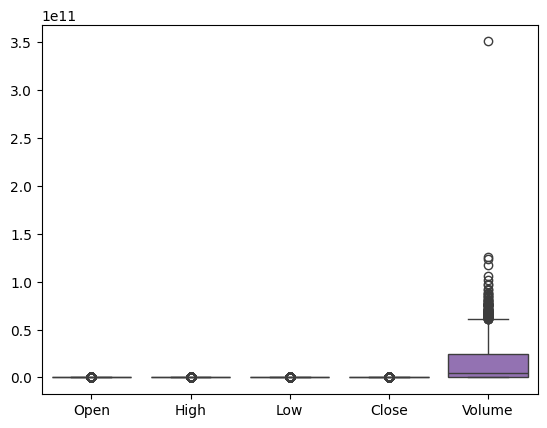

In [ ]:
sns.boxplot(data=df[['Open','High','Low','Close','Volume']])

In [ ]:
Q1 = df[['Open','High','Low','Close','Volume']].quantile(0.25)
Q3 = df[['Open','High','Low','Close','Volume']].quantile(0.75)
IQR = Q3 - Q1
df_clean = df[~((df[['Open','High','Low','Close','Volume']] < (Q1 - 1.5 * IQR)) | (df[['Open','High','Low','Close','Volume']] < (Q1 - 1.5 * IQR))).any(axis=1)]

array([[<Axes: title={'center': 'Open'}>,
        <Axes: title={'center': 'High'}>],
       [<Axes: title={'center': 'Low'}>,
        <Axes: title={'center': 'Close'}>],
       [<Axes: title={'center': 'Volume'}>, <Axes: >]], dtype=object)

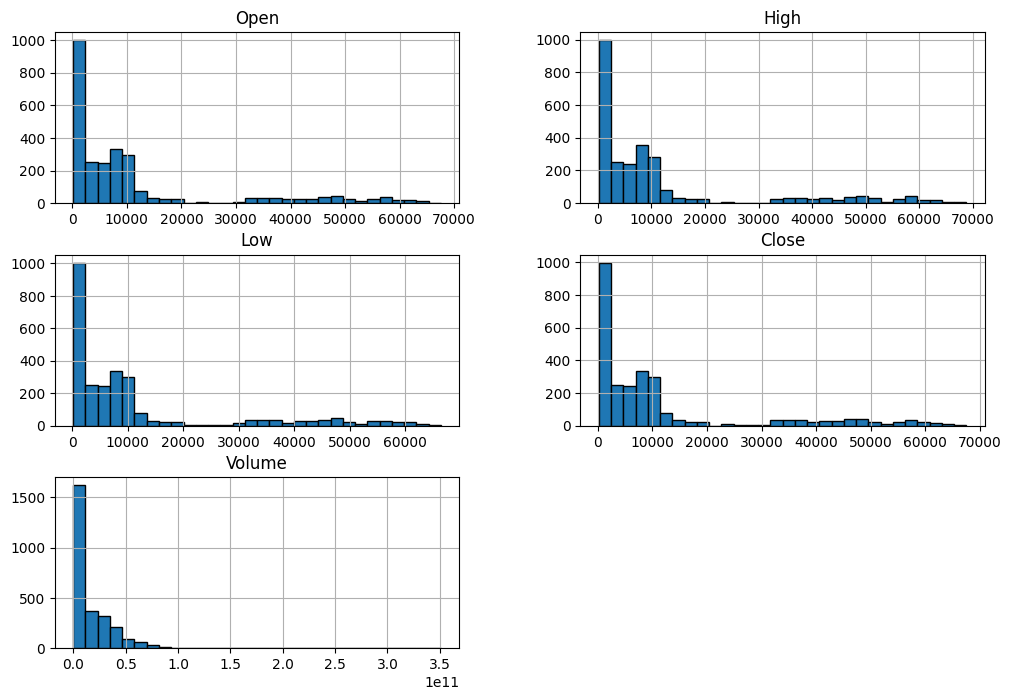

In [ ]:
df_clean[['Open','High','Low','Close','Volume']].hist(bins=30, edgecolor='black', figsize=(12,8))

<Axes: >

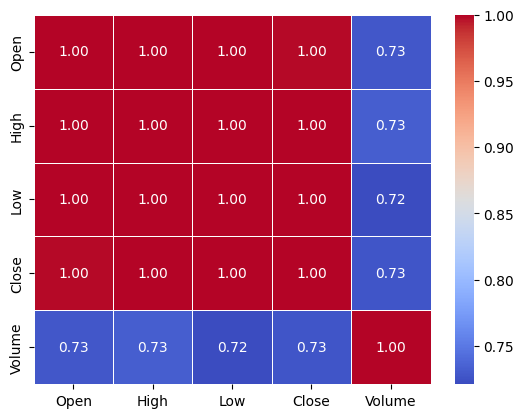

In [ ]:
sns.heatmap(df_clean[['Open','High','Low','Close','Volume']].corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

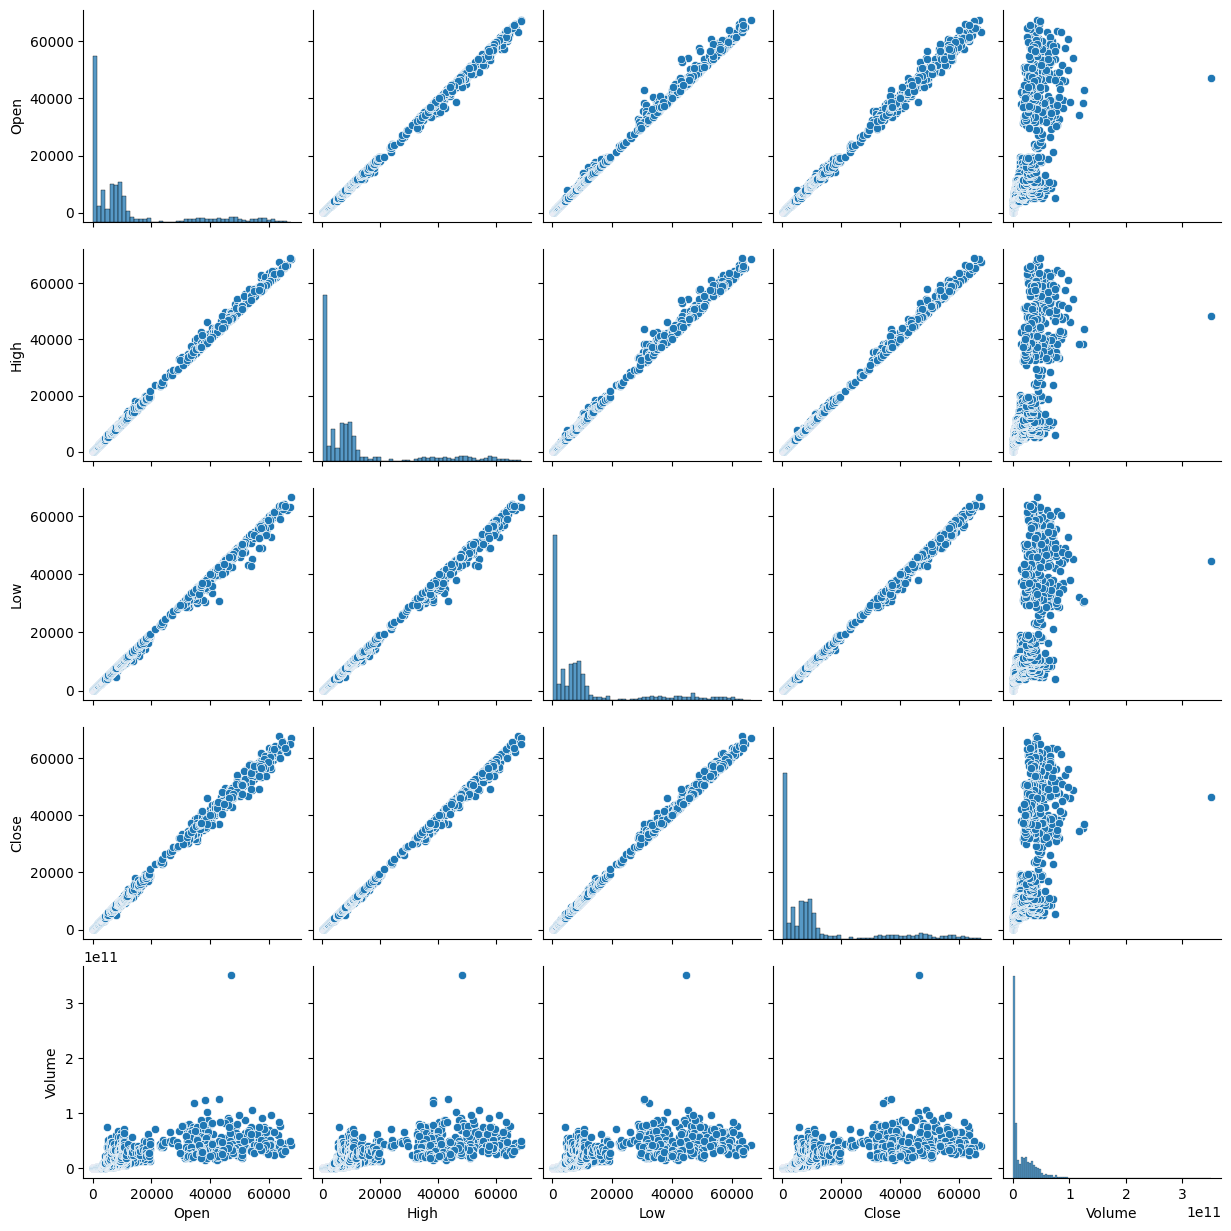

In [ ]:
sns.pairplot(df_clean[['Open','High','Low','Close','Volume']])

Text(0.5, 0, 'Year')

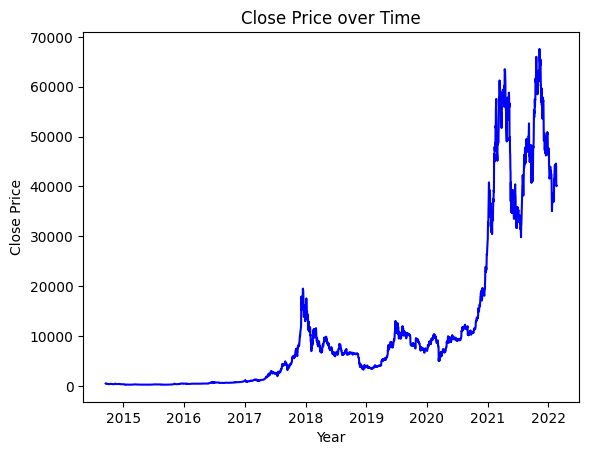

In [ ]:
plt.plot(df_clean.index, df_clean['Close'], label='Close Price', color='blue')
plt.title("Close Price over Time")
plt.ylabel("Close Price")
plt.xlabel("Year")

<Axes: xlabel='Date'>

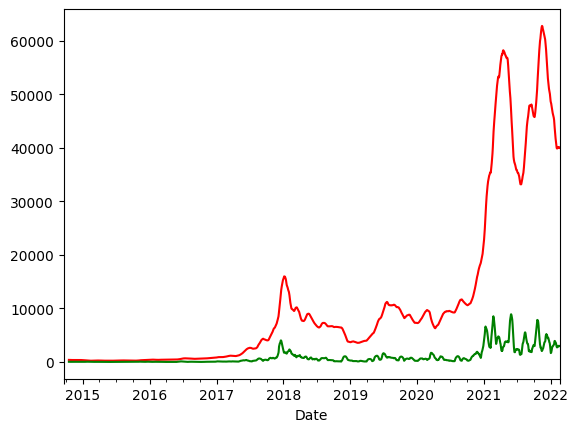

In [ ]:
df_clean['Close'].rolling(window=30).mean().plot(label='30-Day Rolling Mean', color='red')
df_clean['Close'].rolling(window=30).std().plot(label='30-Day Rolling Std Dev', color='green')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [ ]:
df = df.sort_index()

In [ ]:
data = df[['Close']].values
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [ ]:
def create_sequeance(data, seq_length):
  X,y = [], []
  for i in range(len(data) - seq_length):
    X.append(data[i:i+seq_length])
    y.append(data[i+seq_length])
  return np.array(X), np.array(y)

In [ ]:
seq_length = 30
X_lstm, y_lstm = create_sequeance(data_scaled, seq_length)

In [ ]:
train_size = int(len(X_lstm)*0.8)
X_train_lstm, X_test_lstm = X_lstm[:train_size], X_lstm[train_size:]
y_train_lstm, y_test_lstm = y_lstm[:train_size], y_lstm[train_size:]

In [ ]:
df['Target'] = df['Close'].shift(-1)
df.dropna(inplace=True)

In [ ]:
for lag in range(1, seq_length+1):
  df[f'Lag_{lag}'] = df['Close'].shift(lag)
df.dropna(inplace=True)
X_xgb = df.drop(['Target'], axis=1).iloc[:,1:].values
y_xgb = df['Target'].values

In [ ]:
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb, y_xgb, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
lstm_model = Sequential([LSTM(50, return_sequences=True, input_shape=(seq_length, 1)), LSTM(50, return_sequences=False), Dense(25), Dense(1)])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
lstm_model.compile(optimizer='Adam', loss='mean_squared_error')

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
history = lstm_model.fit(X_train_lstm, y_train_lstm, validation_data=(X_test_lstm, y_test_lstm), epochs=50, batch_size=32, callbacks=[early_stop])

Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 7.4751e-04 - val_loss: 0.0034
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 1.0335e-04 - val_loss: 0.0054
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 1.0609e-04 - val_loss: 0.0035
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 8.4975e-05 - val_loss: 0.0075
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 7.3915e-05 - val_loss: 0.0171
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 6.7241e-05 - val_loss: 0.0140


In [ ]:
lstm_predictions = lstm_model.predict(X_test_lstm)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [ ]:
lstm_rmse = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test_lstm), lstm_predictions))
print(f"LSTM RMSE: {lstm_rmse}")

LSTM RMSE: 7965.10414908383


In [ ]:
xgb_model = xgb.XGBRegressor(n_estimstors=500, learning_rate=0.01, max_depths=5, subsample=0.8, colsample_bytree=0.8, random_state=42)
xgb_model.fit(X_train_xgb, y_train_xgb)
xgb_predictions = xgb_model.predict(X_test_xgb)
xgb_rmse = np.sqrt(mean_squared_error(y_test_xgb, xgb_predictions))
print(f"XGBoost RMSE : {xgb_rmse}")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:16:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "max_depths", "n_estimstors" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost RMSE : 6085.620477619782


In [ ]:
import matplotlib.pyplot as plt

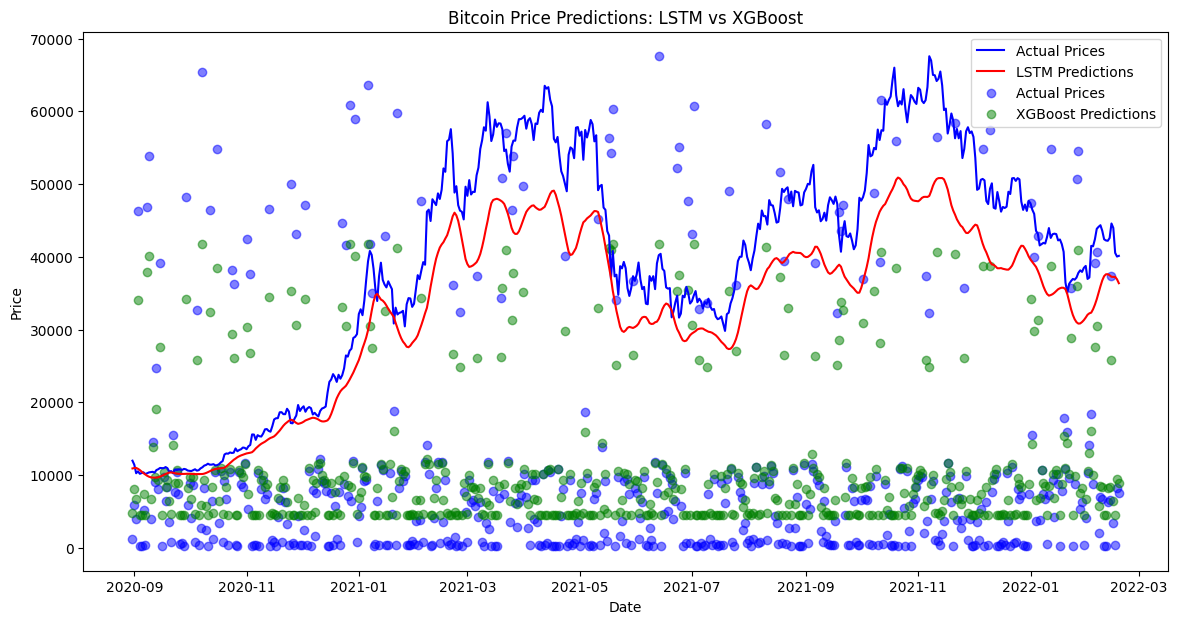

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(df.index[-len(lstm_predictions):], scaler.inverse_transform(y_test_lstm), label='Actual Prices', color='blue')
plt.plot(df.index[-len(lstm_predictions):], lstm_predictions, label='LSTM Predictions', color='red')
plt.scatter(df.index[-len(xgb_predictions):], y_test_xgb, label='Actual Prices', color='blue', alpha=0.5)
plt.scatter(df.index[-len(xgb_predictions):], xgb_predictions, label='XGBoost Predictions', color='green', alpha=0.5)
plt.title('Bitcoin Price Predictions: LSTM vs XGBoost')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()